In [13]:
## 0 - Loading Data

In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer,MaxAbsScaler
from sklearn.pipeline import Pipeline
from util import Util
from cost_data_manager import CostDataManager
from matplotlib.backends.backend_pdf import PdfPages

# configuration
############################################################
np.random.seed(1001)
report_directory = "reports" 

excel_file_video = r"video_dataset_with_costs(cost).xlsx"
excel_file_mrs = r"mrs_dataset_with_costs(cost).xlsx"

# set data mode ('mrs' or 'video')
data_mode = "video"

if data_mode == "mrs":
    excel_file = excel_file_mrs
elif data_mode == "video":
    excel_file = excel_file_video


cost_labels = [
                'Century Link', 
                'Google', 
                'Azure', 
                'Amazon', 
                'Oracle', 
                'Alibaba', 
                'DigitalOcean'
             ]
used_features = ['Users',
                 #'Avg. CPU utilization (%)',
                 'Max CPU utilization (%)',
                 'NW Egress (GB)',
                 #'Avg RAM (unused, KiB)',
                 'Avg RAM used (MB)',
                 #'Disk write bytes rate',
                 #'Disk read bytes',
                 'Used storage(image size, GB)',
                ] 
outcome_label = 'cost'
############################################################

dataManager = CostDataManager(excel_file, outcome_label, cost_labels, used_features, data_mode=data_mode)
dataManager.load()
dataManager.exportDataset()  

def transformX(X):
    scaler = StandardScaler()
    
    #X["Max CPU utilization (%)"] =np.log(X["Max CPU utilization (%)"].values)
    #X["NW Egress (GB)"] = np.sqrt(X["NW Egress (GB)"].values)
    #X["Avg RAM used (MB)"] = np.sqrt(X["Avg RAM used (MB)"].values)
    #X["Max CPU utilization (%)"] = np.log(X["Max CPU utilization (%)"].values)
    X1 = scaler.fit_transform(X)
    X = pd.DataFrame(X1, columns=X.columns)      
    return X

def transformY(Y):
    return Y
    #data = Y.copy().values
    #data = np.sqrt(data)
    #ret = pd.Series(data)
    #return ret 
def invTrans(X):
    return X

dataManager.setXTransform(transformX)
dataManager.setYTransform(transformY)

m_all = dataManager.getMetrics()
if data_mode == 'mrs':
    m_large = dataManager.getMetricsDBLarge()
    m_xlarge = dataManager.getMetricsDBXLarge()
elif data_mode == 'video':
    m_small = dataManager.getMetricsVideoDBLarge()
    m_medium = dataManager.getMetricsVideoDBMedium()
    m_large = dataManager.getMetricsVideoDBSmall()

working_metrics = m_large
working_metrics_label = "large"
print("Total working data:", len(working_metrics))
util = Util()
util.setInvTrans(invTrans)
working_metrics.head()
X,Y = dataManager.getXY_panda(working_metrics)


0 Century Link
1 Google
2 Azure
3 Amazon
4 Oracle
5 Alibaba
6 DigitalOcean
12 features removed (std +/- 3) -  all
7 features removed (std +/- 3) -  large
7 features removed (std +/- 3) -  medium
21 features removed (std +/- 3) -  small
Total working data: 98


In [15]:
test_size = 0.3
metrics = working_metrics
_X,_Y = dataManager.getXY_panda(metrics)

## 1 - Eigendecomposition (eigenvectors and eigenvalues)

### Covariance matrix

In [17]:
X = _X.values
mean_vec = np.mean(X, axis=0)
cov_mat = (X-mean_vec).T.dot(X-mean_vec)/(X.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.01030928e+00  8.36782736e-01  9.78471094e-01  8.51178084e-01
   0.00000000e+00  7.04666308e-18  6.12388945e-18  6.12388945e-18
  -9.14875237e-20 -9.14875237e-20  1.59323499e-17]
 [ 8.36782736e-01  1.01030928e+00  8.81097926e-01  8.63842179e-01
   0.00000000e+00 -1.65075111e-17 -1.54753663e-17 -1.54753663e-17
  -8.55465972e-18 -1.08437794e-17 -1.08437794e-17]
 [ 9.78471094e-01  8.81097926e-01  1.01030928e+00  9.57806928e-01
   0.00000000e+00 -2.27629819e-17  4.49470575e-17  4.03688182e-17
  -2.08001995e-17 -9.35460136e-18 -9.35460136e-18]
 [ 8.51178084e-01  8.63842179e-01  9.57806928e-01  1.01030928e+00
   0.00000000e+00 -1.54931804e-17  5.36810228e-18  7.89863005e-19
  -2.13800624e-18  7.01847232e-18 -2.13800624e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.04666308e-18 -1.65075111e-17 -2.27629819e-17 -1.54931804e-17


In [18]:
### 1.1 - Eigendecomposition

In [19]:
eig_vals, _ = np.linalg.eig(cov_mat)

u,s,v = np.linalg.svd(X.T)
eig_vecs = u

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Eigenvectors 
[[-4.97730119e-01 -1.62717974e-28 -1.85985999e-28 -1.47401146e-28
   6.38063173e-24  2.22308798e-16 -5.78266008e-01  5.85020695e-17
  -4.41665246e-01 -4.72022206e-01 -1.47318435e-27]
 [-4.85203228e-01 -3.01163234e-18 -2.10630174e-18  8.97681399e-19
   1.39079682e-18  1.21764746e-17  7.52046597e-01  9.24027873e-16
  -4.46032634e-01  7.65724713e-03  1.32096641e-28]
 [-5.18097433e-01  7.42448429e-19  6.33905054e-19  8.44708766e-19
  -6.40887092e-19  8.84519958e-19 -2.83554352e-01 -2.07733979e-16
   9.92496446e-02  8.00825504e-01  2.50863835e-27]
 [-4.98415094e-01  2.11539583e-18  1.37766688e-18 -1.90436969e-18
  -6.17765765e-19  5.60155403e-17  1.40111636e-01 -7.30102891e-16
   7.72098574e-01 -3.68530753e-01 -1.26506264e-27]
 [ 0.00000000e+00 -2.63677968e-16 -1.38777878e-17  1.14491749e-16
   5.55111512e-17  0.00000000e+00  0.00000000e+00  8.32667268e-17
   0.00000000e+00  0.00000000e+00 -1.00000000e+00]
 [-1.29995471e-16 -1.87142987e-03 -8.16775497e-03  1.16330973e-02
  -2.

### 1.2 - Selecting Principal Components

In [20]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
3.696891827060959
1.1786941580756043
1.1786941580756036
1.1786941580756027
1.1786941580756018
1.1786941580756
0.19561531455115544
0.16838487972508798
0.14749770765938888
0.0012322641305575434
0.0


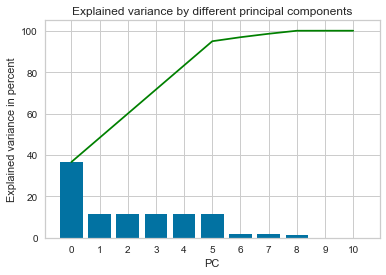

In [21]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

index = np.arange(len(var_exp))
plt.bar(index, var_exp)
plt.xlabel('PC')
plt.ylabel('Explained variance in percent')
plt.xticks(np.array(range(len(var_exp))))
plt.title('Explained variance by different principal components')
plt.plot(index, cum_var_exp, color='green')
plt.show()


In [22]:
# Number of selected principle components
pca_num = 4
eig_pairs_selected = [eig_pairs[i][1].reshape(_X.shape[1],1) for i in range(pca_num)]
matrix_w = np.hstack(eig_pairs_selected)
print('Matrix W:\n', matrix_w)


Matrix W:
 [[-4.97730119e-01 -5.78266008e-01 -4.72022206e-01  5.85020695e-17]
 [-4.85203228e-01  7.52046597e-01  7.65724713e-03  9.24027873e-16]
 [-5.18097433e-01 -2.83554352e-01  8.00825504e-01 -2.07733979e-16]
 [-4.98415094e-01  1.40111636e-01 -3.68530753e-01 -7.30102891e-16]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.32667268e-17]
 [-1.29995471e-16 -3.55067978e-16 -1.67193239e-16  4.08248290e-01]
 [ 2.93711326e-17 -2.30858313e-16 -6.07172344e-18  4.08248290e-01]
 [ 2.92235360e-17 -2.33343262e-16 -6.40719479e-18  4.08248290e-01]
 [ 2.79710946e-17 -2.30212459e-16 -7.58844571e-18  4.08248290e-01]
 [ 2.75869148e-17 -2.32867773e-16 -7.53478562e-18  4.08248290e-01]
 [ 3.03898393e-17 -2.30676080e-16 -6.47416888e-18  4.08248290e-01]]


### 1.3 - Projection to the new feature space

In [27]:
# We're transforming original features X with projection matrix W
# X1 = X x W
X1 = X.dot(matrix_w)

## 2 - Learning with PCA transformed data

In [28]:
# combined from (1.)
def pca_tranform(X, pca_num):
    mean_vec = np.mean(X, axis=0)
    cov_mat = (X-mean_vec).T.dot(X-mean_vec)/(X.shape[0]-1)
    eig_vals, _ = np.linalg.eig(cov_mat)
    u,s,v = np.linalg.svd(X.T)
    eig_vecs = u
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort()
    eig_pairs.reverse()
    eig_pairs_selected = [eig_pairs[i][1].reshape(_X.shape[1],1) for i in range(pca_num)]
    matrix_w = np.hstack(eig_pairs_selected)
    
    return X.dot(matrix_w)


In [29]:
def pcr(X,y,pc):

    Xreg = pca_tranform(X,pc)

    model = LinearRegression()
    model.fit(Xreg, y)

    y_c = model.predict(Xreg)

    y_cv = cross_val_predict(model, Xreg, y, cv=10)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    y2, y_c2 = util.inverse_transform(y, y_c, util.inv_trans)
    y2, y_cv2 = util.inverse_transform(y, y_cv, util.inv_trans)

    # Calculate mean square error for calibration and cross validation
    mae_c = mean_absolute_error(y2, y_c2)
    mae_cv = mean_absolute_error(y2, y_cv2)

    return(y_cv, score_c, score_cv, mae_c, mae_cv, model)

In [26]:
metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
_r2r = []
_r2cv = []
_mser = []
_mscv = []
_predicted = []
max_pca = X.shape[1]
for i in range(1,max_pca):  
    predicted, r2r, r2cv, mser, mscv, model = pcr(X,Y, pc=i)
    _r2r.append(r2r)
    _r2cv.append(r2cv)
    _mser.append(mser)
    _mscv.append(mscv)
    _predicted.append(predicted)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(np.arange(1,max_pca), _r2r, '-vr')
ax1.plot(np.arange(1,max_pca), _r2cv, '-v')
ax1.set_ylabel('R2')
ax1.set_xlabel('Number of principal components in regression')
ax2.plot(np.arange(1,max_pca), _mser, '-vr')
ax2.plot(np.arange(1,max_pca), _mscv, '-v')
ax2.set_ylabel('MAE')
ax2.set_xlabel('Number of principal components in regression')
    
# best case
predicted, r2r, r2cv, mser, mscv, model = pcr(X,Y, pc=4)

# Regression plot
# green line -> ideal 100% correlation between measured and predicted
# blue line -> actual correlation
z = np.polyfit(Y, predicted, 1)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(Y, predicted, c='red', edgecolors='k')
    ax.plot(Y, z[1]+z[0]*Y, c='blue', linewidth=1)
    ax.plot(Y, Y, color='green', linewidth=1)
    plt.title('$R^{2}$ (CV): '+str(r2cv))
    plt.xlabel('Measured $^{\circ}$Brix')
    plt.ylabel('Predicted $^{\circ}$Brix')
    plt.show()
    
util.regression_report(Y, predicted,"PCA", X.shape[1])
regression_models["PCA"] = {'model': model,  'X_train': X, 'X_test': X, 'Y_train': Y, 'Y_test': Y, 'predicted': predicted}
    

NameError: name 'LinearRegression' is not defined